# LOAD LIBRARIES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/NLP Project/serialization_dirs/

Mounted at /content/drive
/content/drive/MyDrive/NLP Project/serialization_dirs


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b3b477c3-e070-4b91-83ef-7ad66ea7d0df)


In [ ]:
!pip install -q -U watermark
!pip install -qq transformers
!pip install -qq wordcloud

%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers,nltk,sklearn

import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import re,string,unicodedata
from string import punctuation
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS

import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, log_loss, precision_recall_fscore_support)
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

     |████████████████████████████████| 1.6 MB 42.4 MB/s 
     |████████████████████████████████| 5.8 MB 27.6 MB/s 
     |████████████████████████████████| 182 kB 75.5 MB/s 
     |████████████████████████████████| 7.6 MB 60.9 MB/s 
Python implementation: CPython
Python version       : 3.8.15
IPython version      : 7.9.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.1+cu113
transformers: 4.25.1
nltk        : 3.7
sklearn     : 1.0.2



# HYPERPARAMETERS

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

TEST_TRAIN_RATIO = 0.4
TEST_VAL_RATIO = 0.5
BATCH_SIZE = 8
MAX_LEN = 512
EPOCHS = 3
FREEZEEMB = True
FREEZEALL = False

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

save_serialization_dir = os.path.join("serialization_dirs")
#if not os.path.exists(save_serialization_dir):
#    os.makedirs(save_serialization_dir)

cuda:0


In [ ]:
model_path = os.path.join(save_serialization_dir, 'BERT_EPOCH_%d_FreezeAll_%s_FreezeEmb_%s_MaxLength_%d.model'%(1, FREEZEALL, FREEZEEMB, MAX_LEN))
print(model_path)

serialization_dirs/BERT_EPOCH_1_FreezeAll_False_FreezeEmb_True_MaxLength_512.model


# IMPORTING THE DATASET

In [ ]:
buzz_false = pd.read_csv("./data/BuzzFeed_fake_news_content.csv")
buzz_true = pd.read_csv("./data/BuzzFeed_real_news_content.csv")
buzz_true['y'] = int(0)
buzz_false['y'] = int(1)
buzz = pd.concat([buzz_true,buzz_false]) #Merging the 2 datasets
buzz1 = buzz.sample(frac=1)
print(buzz1.shape)
## concatenate the title and text
buzz1['sum_text'] = buzz1['title'] + ". " + buzz1['text']

(182, 13)


In [ ]:
wellFake = pd.read_csv("./data/WELFake_Dataset.csv")
wellFake_fake = wellFake.loc[wellFake['label'] == 0].copy()
wellFake_real = wellFake.loc[wellFake['label'] == 1].copy()

wellFake_real['y'] = int(0)
wellFake_fake['y'] = int(1)

wellFake1 = pd.concat([wellFake_real,wellFake_fake]).sample(frac=0.05)
wellFake1 = wellFake1.dropna()
wellFake1['sum_text'] = wellFake1['title'] + ". " + wellFake1['text']
print(wellFake1.shape)

(3573, 6)


In [ ]:
true = pd.read_csv("./data/True.csv")
false = pd.read_csv("./data/Fake.csv")

true['y'] = int(0)
false['y'] = int(1)
df = pd.concat([true,false]) #Merging the 2 datasets
df1 = df.sample(frac=1)

## concatenate the title and text
df1['sum_text'] = df1['title'] + ". " + df1['text']

In [ ]:
nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\.,]', '', text)

# Removing URL's
def remove_URLs(text):
    return re.sub(r'http\S+', '', text)

## remove stop words
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#pre-processing
def pre_processing(text):
    text = remove_between_square_brackets(text)
    text = remove_URLs(text)
    text = remove_stopwords(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df1['sum_text']=df1['sum_text'].apply(pre_processing)
wellFake1['sum_text']=wellFake1['sum_text'].apply(pre_processing)
buzz1['sum_text']=buzz1['sum_text'].apply(pre_processing)

# TRAIN TEST SPLITTING

In [ ]:
df2 = df1[['sum_text', 'y']].copy()
buzz2 = buzz1[['sum_text', 'y']].copy()
wellFake2 = wellFake1[['sum_text', 'y']].copy()

# Spliting datasets 
df_train, df_test = train_test_split(df2, test_size=TEST_TRAIN_RATIO, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=TEST_VAL_RATIO, random_state=RANDOM_SEED)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

print('The max length of tokenizer in bert base model is: ', tokenizer.model_max_length)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

The max length of tokenizer in bert base model is:  512


# GENERATE THE ENCODED DATASET 

In [ ]:
class FakeNewsDataset(Dataset):
    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          truncation=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {'news_content': text, 'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)}

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = FakeNewsDataset(text=df.sum_text.to_numpy(), targets=df.y.to_numpy(),
                         tokenizer=tokenizer, max_len=max_len)
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
buzz_data_loader = create_data_loader(buzz2, tokenizer, MAX_LEN, BATCH_SIZE)
wellFake_data_loader = create_data_loader(wellFake2, tokenizer, MAX_LEN, BATCH_SIZE)

data = next(iter(train_data_loader))
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


# BERT MODEL

In [ ]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, n_classes = 2, dropout=0.1, freeze_emb=False, freeze_all=False):
        super(BertBinaryClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        if(freeze_all):
            # Freeze all layers -> BERT baseline without any training (train only classifier)
            for param in self.bert.parameters():
                param.requires_grad = False
        
        if(freeze_emb):
            # Freeze embeddings only
            for param in self.bert.embeddings.parameters():
                param.requires_grad = False

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask=None):
        pooled_output = self.bert(input_ids, attention_mask=attention_mask).pooler_output
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [ ]:
%%time
model = BertBinaryClassifier(freeze_emb=FREEZEEMB, freeze_all=FREEZEALL)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-6)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  model.train()
  train_loss = 0
  total_correct_predictions, total_predictions = 0, 0

  for step_num, d in enumerate(train_data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    proba = model(input_ids=input_ids, attention_mask=attention_mask)

    _, batch_predictions = torch.max(proba, dim=1)
    total_correct_predictions += torch.sum(batch_predictions == targets)
    total_predictions += targets.shape[0]

    loss_func = nn.CrossEntropyLoss()
    batch_loss = loss_func(proba, targets)
    train_loss += batch_loss.item()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    batch_loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    #model.zero_grad()
    #batch_loss.backward()
    #optimizer.step()

    if step_num % 400 == 0:
      print("\r" + "{0}/{1} loss: {2} Accuracy: {3}".format(step_num, len(train_data_loader), train_loss / (step_num + 1), total_correct_predictions/total_predictions))
  
  # Save the trained model
  model_path = os.path.join(save_serialization_dir, 'BERT_EPOCH_%d_FreezeAll_%s_FreezeEmb_%s_MaxLength_%d.model'%(epoch, FREEZEALL, FREEZEEMB, MAX_LEN))
  torch.save(model.state_dict(), model_path)

  ## evaluation part
  model.eval()
  val_losses = 0
  total_correct_predictions, total_predictions = 0, 0
  with torch.no_grad():
      for step_num, d in enumerate(test_data_loader):
          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)
          targets = d["targets"].to(device)

          proba = model(input_ids=input_ids, attention_mask=attention_mask)
          _, batch_predictions = torch.max(proba, dim=1)
          total_correct_predictions += torch.sum(batch_predictions == targets)
          total_predictions += targets.shape[0]

          loss_func = nn.CrossEntropyLoss()
          batch_loss = loss_func(proba, targets)
          val_losses += batch_loss.item()
  
  val_acc = total_correct_predictions.double() / total_predictions
  val_loss = val_losses / (step_num + 1)
  print(f'Validation loss {val_loss} accuracy {val_acc}')

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

# PREDICT

In [ ]:
model = BertBinaryClassifier(freeze_emb=FREEZEEMB, freeze_all=FREEZEALL)
model_path = os.path.join('BERT_EPOCH_1_FreezeAll_False_FreezeEmb_True_MaxLength_512.model')
model.load_state_dict(torch.load(model_path))
model = model.to(device)

#model = model.eval()

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["news_content"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      probs = F.softmax(outputs, dim=1)
      _, preds = torch.max(outputs, dim=1)
  
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_val = get_predictions(model, val_data_loader)

In [ ]:
class_names = ['Real', 'Fake']
print(classification_report(y_val, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4252
        Fake       1.00      1.00      1.00      4728

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# PREDICT ON WELFAKE

In [ ]:
y_wellFake_review_texts, y_wellFake_pred, y_wellFake_pred_probs, y_wellFake = get_predictions(model, wellFake_data_loader)

In [ ]:
class_names = ['Real', 'Fake']
print(classification_report(y_wellFake, y_wellFake_pred, target_names=class_names))

              precision    recall  f1-score   support

        Real       0.10      0.09      0.09      1805
        Fake       0.17      0.20      0.18      1768

    accuracy                           0.14      3573
   macro avg       0.14      0.14      0.14      3573
weighted avg       0.14      0.14      0.14      3573



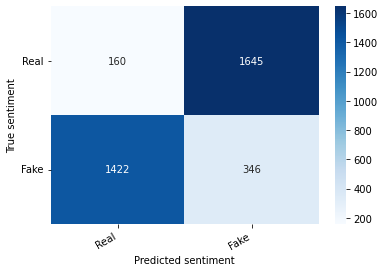

In [ ]:
cm = confusion_matrix(y_wellFake, y_wellFake_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# PREDICT ON BUZZFEED

In [ ]:
y_buzz_review_texts, y_buzz_pred, y_buzz_pred_probs, y_buzz = get_predictions(model, buzz_data_loader)

In [ ]:
class_names = ['Real', 'Fake']
print(classification_report(y_buzz, y_buzz_pred, target_names=class_names))

              precision    recall  f1-score   support

        Real       0.93      0.41      0.56        91
        Fake       0.62      0.97      0.76        91

    accuracy                           0.69       182
   macro avg       0.77      0.69      0.66       182
weighted avg       0.77      0.69      0.66       182



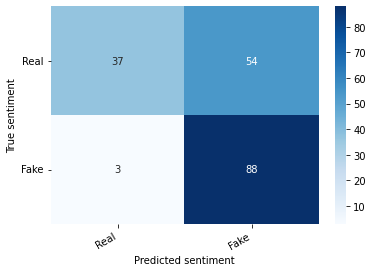

In [ ]:
cm = confusion_matrix(y_buzz, y_buzz_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# INFERENCE - WORD IMPORTANCE

In [ ]:
import json

def get_filtered_words(sentence):
    PUNCT_TO_REMOVE = string.punctuation
    sentence = sentence.lower()
    temp_sentence = sentence.translate(str.maketrans('', '',PUNCT_TO_REMOVE))
    temp_sentence = " ".join(temp_sentence.split()) #extra spaces
    temp_sentence = temp_sentence.split(" ")
    filtered_words = [word for word in temp_sentence if word not in stopwords.words('english')]
    filtered_words = set([word for word in filtered_words if len(word) > 3]) #get the unique word length >3

    return filtered_words

def get_probs(model, sentence):
  encoding = tokenizer.encode_plus(sentence, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, 
                                    truncation=True, padding='max_length', return_attention_mask=True, return_tensors='pt')
  encoding = encoding.to(device)
  outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
  probs = F.softmax(outputs, dim=1)
  return probs

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [ ]:
def word_importance(model, sentence):
  with torch.no_grad():
    prob_score = {}
    probs = get_probs(model, sentence)
    prob_score['Total_sentence'] = probs.reshape(-1)

    filtered_words = get_filtered_words(sentence)
    for word in filtered_words:
        new_sentence = sentence.replace(word,'')
        new_probs = get_probs(model, new_sentence) #getting prediction probability with word
        prob_score[word] = new_probs.reshape(-1)

  same_class_pos_impact = {}
  same_class_neg_impact = {}
  diff_class_pos_impact = {}
  diff_class_neg_impact = {}
  for word in prob_score:
      _, init_class_pred = torch.max(prob_score['Total_sentence'], dim=0)
      if word != 'Total_sentence':
        _, class_pred = torch.max(prob_score[word], dim=0)
        prob_score[word] = prob_score['Total_sentence'] - prob_score[word]
        perc_change = abs(prob_score[word][class_pred]) * 100
        if (init_class_pred != class_pred):
            #prediction shift...
            if prob_score[word][class_pred] > 0:
                diff_class_pos_impact[word] = perc_change
            else:
                diff_class_neg_impact[word] = perc_change
        else:
            # same class prediction...
            if prob_score[word][class_pred] > 0:
                same_class_pos_impact[word] = perc_change
            else:
                same_class_neg_impact[word] = perc_change
  return same_class_pos_impact, same_class_neg_impact, diff_class_pos_impact, diff_class_neg_impact, init_class_pred

In [ ]:
testset = df_val.sample(n=500, random_state=RANDOM_SEED) 
print(testset.shape)

test_result = []
for i in tqdm(range(testset.shape[0])):
  sentence = testset.iloc[i]['sum_text']
  target = testset.iloc[i]['y']
  scpi,scni,dcpi,dcni,pred_tar = word_importance(model, sentence)
  test_result.append([scpi,scni,dcpi,dcni,pred_tar, sentence, target])

with open('BERT_512Token_word_importance_sampledtest_set.pickle', 'wb') as handle:
  pickle.dump(test_result, handle)

In [ ]:
from tqdm import tqdm

buzz_result = []
for i in tqdm(range(buzz2.shape[0])):
  sentence = buzz2.iloc[i]['sum_text']
  target = buzz2.iloc[i]['y']
  scpi,scni,dcpi,dcni,pred_tar = word_importance(model, sentence)
  buzz_result.append([scpi,scni,dcpi,dcni,pred_tar, sentence, target])

100%|██████████| 182/182 [23:56<00:00,  7.89s/it]


TypeError: ignored

In [ ]:
import pickle

with open('BERT_512Token_word_importance_buzz_set.pickle', 'wb') as handle:
    pickle.dump(buzz_result, handle)